In [1]:
!pip install transformers
!pip install torch

     |████████████████████████████████| 4.0 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 30.0 MB/s 
     |████████████████████████████████| 6.6 MB 32.2 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 880 kB 37.9 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=64aa75e297e65190f4a31ba8d6877fa5468698db251382b8f85332e61d31aa8a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import transformers

MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 8
EPOCHS = 3
TRAINING_FILE = "/content/drive/MyDrive/ner_dataset.csv"
# MODEL_PATH="/content/drive/MyDrive/BERT_model.pt"
TOKENIZER = transformers.RobertaTokenizer.from_pretrained("roberta-base",do_lower_case=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [4]:
!pip install torch

In [6]:
import torch


class EntityDataset:
    def __init__(self, texts, pos, tags):
        # example format:
        # texts: [["hi", ",", "my", "name", "is", "shikhar"], ["hello".....]]
        # pos/tags: [[1 2 3 4 1 5], [....].....]]
        self.texts = texts
        self.pos = pos
        self.tags = tags
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        pos = self.pos[item]
        tags = self.tags[item]

        ids = []
        target_pos = []
        target_tag =[]

        for i, s in enumerate(text):
            inputs = TOKENIZER.encode(
                s,
                add_special_tokens=False
            )
            # 'shikhar' might get further tokenized into subwords:
            # shikhar: ##s ##hi ##kh ##ar
            
            input_len = len(inputs)
            ids.extend(inputs)
            target_pos.extend([pos[i]] * input_len)
            target_tag.extend([tags[i]] * input_len)

        ids = ids[:MAX_LEN - 2]
        target_pos = target_pos[:MAX_LEN - 2]
        target_tag = target_tag[:MAX_LEN - 2]

        ids = [101] + ids + [102]
        target_pos = [0] + target_pos + [0]
        target_tag = [0] + target_tag + [0]

        mask = [1] * len(ids)
        token_type_ids = [0] * len(ids)

        padding_len = MAX_LEN - len(ids)

        ids = ids + ([0] * padding_len)
        mask = mask + ([0] * padding_len)
        token_type_ids = token_type_ids + ([0] * padding_len)
        target_pos = target_pos + ([0] * padding_len)
        target_tag = target_tag + ([0] * padding_len)

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "target_pos": torch.tensor(target_pos, dtype=torch.long),
            "target_tag": torch.tensor(target_tag, dtype=torch.long),
        }

In [7]:
#preprocessing the dataset

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection

def process_data(data_path):
    df = pd.read_csv(data_path, encoding="latin-1")
    df.loc[:, "Sentence #"] = df["Sentence #"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "POS"] = enc_pos.fit_transform(df["POS"])
    df.loc[:, "Tag"] = enc_tag.fit_transform(df["Tag"])

    sentences = df.groupby("Sentence #")["Word"].apply(list).values
    pos = df.groupby("Sentence #")["POS"].apply(list).values
    tag = df.groupby("Sentence #")["Tag"].apply(list).values
    
    return sentences, pos, tag, enc_pos, enc_tag

In [8]:
sentences, pos, tag, enc_pos, enc_tag = process_data(TRAINING_FILE)

num_pos = len(list(enc_pos.classes_))
num_tag = len(list(enc_tag.classes_))

(   
    train_sentences,
    test_sentences,
    train_pos,
    test_pos,
    train_tag,
    test_tag
 
) = model_selection.train_test_split(sentences, pos, tag, random_state=42, test_size=0.1)


train_dataset = EntityDataset(
        texts=train_sentences, pos=train_pos, tags=train_tag
    )

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4
)

valid_dataset = EntityDataset(
    texts=test_sentences, pos=test_pos, tags=test_tag
)

valid_data_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=1
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
import torch.nn as nn

In [15]:
def loss_fn(output, target, mask, num_labels):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1
    active_logits = output.view(-1, num_labels)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)
    )
    loss = lfn(active_logits, active_labels)
    return loss


class EntityModel(nn.Module):
    def __init__(self, num_tag, num_pos):
        super(EntityModel, self).__init__()
        self.num_tag = num_tag
        self.num_pos = num_pos
        self.bert = transformers.RobertaModel.from_pretrained("roberta-base",return_dict=False)
        self.bert_drop_1 = nn.Dropout(0.3)
        self.bert_drop_2 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, self.num_tag)
        self.out_pos = nn.Linear(768, self.num_pos)
    
    def forward(self, ids, mask, token_type_ids, target_pos, target_tag):
        o1, _ = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)

        bo_tag = self.bert_drop_1(o1)
        bo_pos = self.bert_drop_2(o1)

        tag = self.out_tag(bo_tag)
        pos = self.out_pos(bo_pos)

        loss_tag = loss_fn(tag, target_tag, mask, self.num_tag)
        loss_pos = loss_fn(pos, target_pos, mask, self.num_pos)

        loss = (loss_tag + loss_pos) / 2

        return tag, pos, loss

In [10]:
!pip install tqdm

In [16]:
from tqdm import tqdm

def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()  #puts the model into training mode.It doesn't perform the training
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        optimizer.zero_grad()
        _, _, loss = model(**data)
        loss.backward()
        optimizer.step()  # Update parameters and take a step using the computed gradient.
        scheduler.step()  # Update the learning rate.
        final_loss += loss.item()
    return final_loss / len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    final_loss = 0
    for data in tqdm(data_loader, total=len(data_loader)):
        for k, v in data.items():
            data[k] = v.to(device)
        _, _, loss= model(**data)
        final_loss += loss.item()
    return final_loss / len(data_loader)

In [17]:
device = torch.device("cuda")
model = EntityModel(num_tag=num_tag, num_pos=num_pos)
model.to(device)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EntityModel(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), 

In [18]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

num_train_steps = int(len(train_sentences) / TRAIN_BATCH_SIZE * EPOCHS) #not same as no. of training samples
 
optimizer = AdamW(optimizer_parameters, lr=3e-5)

scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [20]:
best_loss = np.inf
training_stats=[]

for epoch in range(EPOCHS):
    train_loss =train_fn(train_data_loader, model, optimizer, device, scheduler)
    test_loss = eval_fn(valid_data_loader, model, device)

    training_stats.append({'epoch':  epoch + 1,'Training Loss': train_loss,'Test Loss': test_loss,})

    print(f"Train Loss = {train_loss} Valid Loss = {test_loss}")
    if test_loss < best_loss:
        # torch.save(model.state_dict(), MODEL_PATH)
        best_loss = test_loss

  0%|          | 0/1349 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 600/600 [01:16<00:00,  7.89it/s]


Train Loss = 0.21581372305518878 Valid Loss = 0.10737567974254489


100%|██████████| 600/600 [01:16<00:00,  7.88it/s]


Train Loss = 0.10095161154833081 Valid Loss = 0.09543679588474334


100%|██████████| 600/600 [01:15<00:00,  7.91it/s]

Train Loss = 0.08492184883802356 Valid Loss = 0.09197252003941685


In [21]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 4)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Test Loss
epoch,,
1,0.2158,0.1074
2,0.1010,0.0954
3,0.0849,0.0920


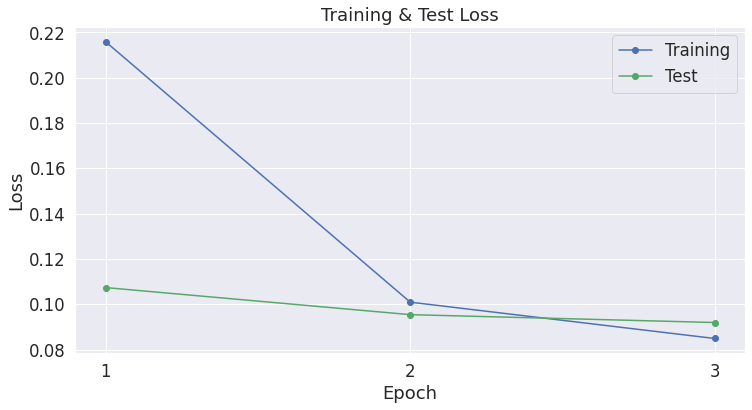

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Test Loss'], 'g-o', label="Test")

# Label the plot.
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()